In [1]:
import numpy as np
import open3d as o3d
import json
import os
from tqdm import tqdm
import pandas as pd
import copy

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
import statistics as st
from sklearn.model_selection import GridSearchCV

from pyquaternion import Quaternion
import os.path as osp

from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.eval.detection.evaluate import DetectionEval
from nuscenes.eval.detection.data_classes import DetectionConfig
from utils.vis import plot_3d_image_
from utils.misc import *
from utils.eval import box3d_iou

%matplotlib inline

In [2]:
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.515 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## CSV creation

Creating the principal components of each point cloud

In [13]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to retrieve point clous features
features_path =  os.getcwd() + '/dataset/point_features_path/'

# Segmented pointd cloud paths
segmentation_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# Matrix of principal components
components_mat = []

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]
            #print(annotation_metadata['sample_token'])
                        
            # Read segmented point cloud
            pcd = o3d.io.read_point_cloud(annotation_metadata['pcd_path'])
            
            # Save the point cloud as a numpy array
            points_xyz = np.asarray(pcd.points)
            
            # Extract the principal components of the point cloud
            pca_pcl = PCA(n_components = 1).fit(points_xyz) 
            
            # Save the components unitary vector
            components_mat.append(pca_pcl.components_.squeeze())



# Transform the components_mat as a numpy array
components_mat = np.array(components_mat)

print('The shape of the components matrix is: {}'.format(components_mat.shape))

Sample files: 100%|██████████| 404/404 [00:01<00:00, 362.80it/s]

The shape of the components matrix is: (1419, 3)


### Computing the dot product between the LiDAR frame and point cloud orientation

In [14]:
# Text one PCA value for X
idx = 75 # 120
print('The PCA value is: {}'.format(components_mat[idx, :]))

lidar = np.array([1, 0, 0]) # column vector
pcl_segmented = components_mat[idx, :]

print('The Lidar Vector is: {}'.format(lidar))
print('The point cloud principal components are: {}'.format(pcl_segmented))

dotProd = lidar.dot(pcl_segmented)
normProd= np.linalg.norm(lidar) * np.linalg.norm(pcl_segmented)
cos_angle = np.arccos(dotProd / normProd)

print('The arccos value of a simple sample is: {}'.format(cos_angle))

The PCA value is: [-0.17091799 -0.98499499 -0.02391459]
The Lidar Vector is: [1 0 0]
The point cloud principal components are: [-0.17091799 -0.98499499 -0.02391459]
The arccos value of a simple sample is: 1.7425576198364356


## Loop to create the features and targets file

The CSV file has the targets, features, and useful metadata to plot the instance of interest, class, etc.

In [15]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to retrieve point clous features
features_path =  os.getcwd() + '/dataset/point_features_path/'

# Matrix to store the features' vectors
features_matrix = []
# Dictionary of targets
targets_dic = {'x_pos': [], 'y_pos': [], 'z_pos': [], 'width': [], 'lenght': [], 'height': [], 'yaw': []}

tokens_dic = {'sample_token': [], 'camera_token': [], 'annotation_token': [], 'category': []}

# Vectors to compute orientations
vec_x = np.array([1, 0, 0]) 
vec_y = np.array([0, 1, 0]) 
vec_z = np.array([0, 0, 1]) 

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]
            
            # Point cloud
            pcd = o3d.io.read_point_cloud(annotation_metadata['pcd_path'])            
            
            pointcloud = np.asarray(pcd.points).T
            
            # Mean
            mean_x = st.mean(pointcloud[0,:])
            mean_y = st.mean(pointcloud[1,:])
            mean_z = st.mean(pointcloud[2,:])
            
            # Median
            median_x = st.median(pointcloud[0,:])
            median_y = st.median(pointcloud[1,:])
            median_z = st.median(pointcloud[2,:])
            
            # Middle
            middle_x = middle_func(pointcloud[0,:])
            middle_y = middle_func(pointcloud[1,:])
            middle_z = middle_func(pointcloud[2,:])            

            # Retrieve instance's features
            features_vec = parse_features_to_numpy(annotation_metadata['point_features_path'])
            
            # matrix with the points arranged as M x 3
            points_xyz = np.asarray(pcd.points)
            
            # Extract the principal components of the point cloud
            pca_pcl = PCA(n_components = 1).fit(points_xyz) 
            pcl_vec = pca_pcl.components_.squeeze()
            
            # dot, cross and norm product for x axis
            dotProd_x = vec_x.dot(pcl_vec)
            crossProd_x = np.linalg.norm(np.cross(vec_x, pcl_vec))
            normProd_x = np.linalg.norm(vec_x) * np.linalg.norm(pcl_vec)
            
            # dot, cross and norm product for y axis
            dotProd_y = vec_y.dot(pcl_vec)
            crossProd_y = np.linalg.norm(np.cross(vec_y, pcl_vec))
            normProd_y = np.linalg.norm(vec_y) * np.linalg.norm(pcl_vec)
            
            # dot, cross and norm product for z axis
            dotProd_z = vec_z.dot(pcl_vec)
            crossProd_z = np.linalg.norm(np.cross(vec_z, pcl_vec))
            normProd_z = np.linalg.norm(vec_z) * np.linalg.norm(pcl_vec)            
            
            # Compute the cos values for each axis
            roll_x = np.arccos( dotProd_x / (normProd_x))
            pitch_y = np.arccos( dotProd_y / (normProd_y))
            yaw_z = np.arccos( dotProd_z / (normProd_z))
            
            # Compute oposite cos values  
            opo_roll_x = roll_x - np.pi
            opo_pitch_y = pitch_y - np.pi
            opo_yaw_z = yaw_z - np.pi                   
            
            # Add mean meadian and middle to features matrix
            features_vec = np.hstack([features_vec, mean_x, mean_y, mean_z, median_x, 
                                      median_y, median_z, middle_x, middle_y, middle_z, roll_x,
                                     pitch_y, yaw_z, -roll_x, -pitch_y, -yaw_z, opo_roll_x,
                                     opo_pitch_y, opo_yaw_z])
                                     #np.pi - roll_x, np.pi - pitch_y, np.pi - yaw_z,
                                     #roll_x - np.pi, pitch_y - np.pi, yaw_z - np.pi])
            
            # Store the current feature vector in the features' matrix
            features_matrix.append(list(features_vec))
            
            # Extract class targets
            pose = annotation_metadata['position_coord']
            dims = annotation_metadata['wlh_values']
            yaw = annotation_metadata['orientation_value']
            label = annotation_metadata['category']
            
            # Save X, Y and Z pose
            targets_dic['x_pos'].append(pose[0])
            targets_dic['y_pos'].append(pose[1])
            targets_dic['z_pos'].append(pose[2])
            
            # Store target size
            targets_dic['width'].append(dims[0])
            targets_dic['lenght'].append(dims[1])
            targets_dic['height'].append(dims[2])
            
            # Save the orientations in such way that the rotation matrix is always 1
            if annotation_metadata['rotation_axis'] > 0:
                # Store target orientation
                targets_dic['yaw'].append(yaw)
            else:
                targets_dic['yaw'].append(-yaw)
                
            
            # Store sample, camera and annotation token
            tokens_dic['sample_token'].append(annotation_metadata['sample_token'])
            tokens_dic['camera_token'].append(annotation_metadata['camera_token'])
            tokens_dic['annotation_token'].append(annotation_metadata['annotation_token'])
            tokens_dic['category'].append(annotation_metadata['category'])  
            
            
# Parse features as a numpy array
features_matrix = np.array(features_matrix)

# Create a dataframe of features
df_features = pd.DataFrame(data = features_matrix)
# Create a dataframe of targets
df_targets = pd.DataFrame.from_dict(targets_dic)
# Create a dataframe of tokens
df_tokens = pd.DataFrame.from_dict(tokens_dic)

# Concat both dataframes horizontally to create the final dataframe
df_detection = pd.concat([df_features, df_targets, df_tokens], axis=1)
df_detection.head()

df_detection.to_csv('dataset/3d_obj_detection.csv')

Sample files: 100%|██████████| 404/404 [00:09<00:00, 42.51it/s]


## Loading CSV and parsing info as a numpy array

In [3]:
# Load dataframe form CSV file
df_detection_csv = pd.read_csv('dataset/3d_obj_detection.csv')
# features: 1 - 640 // targets: 641 - 648
        
print('The Dataframe shape is {}'.format(df_detection_csv.shape))
print('The targets keys are',df_detection_csv.keys()[659:666])
#print('The targets keys are',df_detection_csv.keys()[656:663])
# Parse features and targets to numpy array\n",
features = df_detection_csv.loc[:,'0':'657'].to_numpy()
#features = df_detection_csv.loc[:,'0':'654'].to_numpy()
targets = df_detection_csv.loc[:,'x_pos':'category']
print('The Features shape is {}'.format(features.shape))
print('The Targets shape is {}'.format(targets.shape))

The Dataframe shape is (1411, 670)
The targets keys are Index(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], dtype='object')
The Features shape is (1411, 658)
The Targets shape is (1411, 11)


## Splitting and scaling the data

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import Normalizer 

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)

print('Train set features size: \n {}'.format(X_train.shape))
print('Test set featires size: \n {}'.format(X_test.shape))
print('Train set targets size: \n {}'.format(y_train.shape))
print('Test set targets size: \n {}'.format(y_test.shape))

y_train_tokens = y_train.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_test_tokens =  y_test.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_train = y_train.loc[:,'x_pos':'yaw'].to_numpy()
y_test = y_test.loc[:,'x_pos':'yaw'].to_numpy()

# transform orientation from degres to rad
y_train_yaw = y_train[:, 6]
#y_train[:, 6] = (np.sin(np.deg2rad(y_train_yaw))*2)+2
y_train[:, 6] = np.deg2rad(y_train_yaw)

y_test_yaw = y_test[:, 6]
#y_test[:, 6] = (np.sin(np.deg2rad(y_test_yaw))*2)+2
y_test[:, 6] = np.deg2rad(y_test_yaw)

Train set features size: 
 (1128, 658)
Test set featires size: 
 (283, 658)
Train set targets size: 
 (1128, 11)
Test set targets size: 
 (283, 11)


## Transformation

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
### Grid Search for SVR 

In [56]:
from sklearn.svm import SVR
tuned_parameters = [{'estimator__kernel': ['linear', 'poly', 'rbf'], 
                     'estimator__C': [1,0.5],
                     'estimator__epsilon': [1,0.1]}]

svr_mo = MultiOutputRegressor(SVR())

gs_svr = GridSearchCV(svr_mo, tuned_parameters)
gs_svr.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_svr.best_params_)

means = gs_svr.cv_results_['mean_test_score']
for mean,params in zip(means, gs_svr.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.713 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}

Best Hyperparameters found are:
{'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}
0.464 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'linear'}
0.433 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'poly'}
0.309 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'rbf'}
0.654 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'linear'}
0.684 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}
0.581 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'rbf'}
0.465 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'linear'}
0.398 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'poly'}
0.244 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'rbf'}
0.669 for {'estimator__C': 0.5, 'estimator__epsilon': 0.1, 'estimator__kernel': 'linear'}
0.645 for {'estimator__C': 0.5,

### Scores with best Hyperparameters for SVR

In [6]:
from sklearn.svm import SVR

svr_mo = MultiOutputRegressor(SVR(C = 1, epsilon = 0.1, kernel = 'poly', degree = 3))
svr_mo.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(svr_mo.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(svr_mo.score(X_test_scaled, y_test)))

Training set score is: 0.848
Test set score is: 0.709


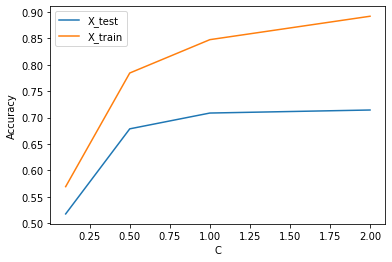

In [61]:
c_range = [2,1,0.5,0.1]
scores_test = []
scores_train=[]

for c in c_range:
    model_svr = svr_mo = MultiOutputRegressor(SVR(C = c, epsilon = 0.1, kernel = 'poly', degree = 3))
    model_svr.fit(X_train_scaled, y_train)
    scores_test.append(model_svr.score(X_test_scaled, y_test))
    scores_train.append(model_svr.score(X_train_scaled, y_train))

plt.xlabel('C')
plt.ylabel('Accuracy')

plt.plot(c_range, scores_test)
plt.plot(c_range, scores_train)
plt.legend(('X_test','X_train'))

---
### Grid Search for Lasso

In [13]:
from sklearn import linear_model

tuned_parameters = [{'estimator__normalize': [True, False], 
                     'estimator__alpha': [1,0.5,0.005,0.001]}]

m_lasso = MultiOutputRegressor(linear_model.Lasso(max_iter = 5000))

gs_lasso = GridSearchCV(m_lasso, tuned_parameters)
gs_lasso.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_lasso.best_params_)

means = gs_lasso.cv_results_['mean_test_score']
for mean,params in zip(means, gs_lasso.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.692 for {'estimator__alpha': 0.001, 'estimator__normalize': False}

Best Hyperparameters found are:
{'estimator__alpha': 0.001, 'estimator__normalize': False}
-0.004 for {'estimator__alpha': 1, 'estimator__normalize': True}
0.175 for {'estimator__alpha': 1, 'estimator__normalize': False}
-0.004 for {'estimator__alpha': 0.5, 'estimator__normalize': True}
0.228 for {'estimator__alpha': 0.5, 'estimator__normalize': False}
0.585 for {'estimator__alpha': 0.005, 'estimator__normalize': True}
0.681 for {'estimator__alpha': 0.005, 'estimator__normalize': False}
0.679 for {'estimator__alpha': 0.001, 'estimator__normalize': True}
0.683 for {'estimator__alpha': 0.001, 'estimator__normalize': False}


### Scores with best Hyperparameters for Lasso

In [65]:
from sklearn import linear_model

m_lasso = MultiOutputRegressor(linear_model.Lasso(max_iter = 5000, alpha = 0.001, normalize = False))

m_lasso.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(m_lasso.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(m_lasso.score(X_test_scaled, y_test)))

Training set score is: 0.795
Test set score is: 0.673


---
### Grid Search for RandomForestRegressor 

In [7]:
from sklearn.ensemble import RandomForestRegressor

tuned_parameters = [{ 'criterion' : ['mse', 'mae'], 
                     'n_estimators': [50,100]}]

rfr = RandomForestRegressor(random_state = 123)

gs_rfr = GridSearchCV(rfr, tuned_parameters)
gs_rfr.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_rfr.best_params_)

means = gs_rfr.cv_results_['mean_test_score']
for mean,params in zip(means, gs_rfr.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.744 for {'criterion': 'mae', 'n_estimators': 100}

Best Hyperparameters found are:
{'criterion': 'mae', 'n_estimators': 100}
0.730 for {'criterion': 'mse', 'n_estimators': 50}
0.735 for {'criterion': 'mse', 'n_estimators': 100}
0.743 for {'criterion': 'mae', 'n_estimators': 50}
0.744 for {'criterion': 'mae', 'n_estimators': 100}


### Scores with best Hyperparameters for Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state = 123,criterion = 'mae', n_estimators = 100)
rfr.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(rfr.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(rfr.score(X_test_scaled, y_test)))

KeyboardInterrupt: 

---
## R2 Score for every Target

Using SVR

In [7]:
from sklearn.metrics import r2_score

# Predictions for Train and Test set
prediction_test = svr_mo.predict(X_test_scaled)
prediction_train = svr_mo.predict(X_train_scaled)

# Compute R^2 (coefficient of determination) regression score for each output
x_score_train = r2_score(y_train[:,0], prediction_train[:,0])
y_score_train = r2_score(y_train[:,1], prediction_train[:,1])
z_score_train = r2_score(y_train[:,2], prediction_train[:,2])
w_score_train = r2_score(y_train[:,3], prediction_train[:,3])
l_score_train = r2_score(y_train[:,4], prediction_train[:,4])
h_score_train = r2_score(y_train[:,5], prediction_train[:,5])
yaw_score_train = r2_score(y_train[:,6], prediction_train[:,6])
total_score_train= (x_score_train + y_score_train + z_score_train +
                    w_score_train + l_score_train + h_score_train +
                    yaw_score_train)/7

x_score_test = r2_score(y_test[:,0], prediction_test[:,0])
y_score_test = r2_score(y_test[:,1], prediction_test[:,1])
z_score_test = r2_score(y_test[:,2], prediction_test[:,2])
w_score_test = r2_score(y_test[:,3], prediction_test[:,3])
l_score_test = r2_score(y_test[:,4], prediction_test[:,4])
h_score_test = r2_score(y_test[:,5], prediction_test[:,5])
yaw_score_test = r2_score(y_test[:,6], prediction_test[:,6])
total_score_test = (x_score_test + y_score_test + z_score_test +
                    w_score_test + l_score_test + h_score_test +
                    yaw_score_test)/7

print('Train: ')
print('R2 Score for X in Train set: {:.3f}'.format(x_score_train))
print('R2 Score for Y in Train set: {:.3f}'.format(y_score_train))
print('R2 Score for Z in Train set: {:.3f}'.format(z_score_train))
print('R2 Score for Width in Train set: {:.3f}'.format(w_score_train))
print('R2 Score for Length in Train set: {:.3f}'.format(l_score_train))
print('R2 Score for Height in Train set: {:.3f}'.format(h_score_train))
print('R2 Score for Yaw in Train set: {:.3f}'.format(yaw_score_train))
print('Average score Train: {:.3f}\n'.format(total_score_train))

print('Test: ')
print('R2 Score for X in Test set: {:.3f}'.format(x_score_test))
print('R2 Score for Y in Test set: {:.3f}'.format(y_score_test))
print('R2 Score for Z in Test set: {:.3f}'.format(z_score_test))
print('R2 Score for Width in Test set: {:.3f}'.format(w_score_test))
print('R2 Score for Length in Test set: {:.3f}'.format(l_score_test))
print('R2 Score for Height in Test set: {:.3f}'.format(h_score_test))
print('R2 Score for Yaw in Test set: {:.3f}'.format(yaw_score_test))
print('Average score Test: {:.3f}'.format(total_score_test))

Train: 
R2 Score for X in Train set: 0.927
R2 Score for Y in Train set: 0.922
R2 Score for Z in Train set: 0.964
R2 Score for Width in Train set: 0.803
R2 Score for Length in Train set: 0.804
R2 Score for Height in Train set: 0.939
R2 Score for Yaw in Train set: 0.574
Average score Train: 0.848

Test: 
R2 Score for X in Test set: 0.909
R2 Score for Y in Test set: 0.940
R2 Score for Z in Test set: 0.891
R2 Score for Width in Test set: 0.467
R2 Score for Length in Test set: 0.698
R2 Score for Height in Test set: 0.748
R2 Score for Yaw in Test set: 0.308
Average score Test: 0.709


---
## Visualizing 3D plot

Predicted values:  [[ 0.20307411 14.78864102 -0.56725205  1.84835819  4.44928852  1.69381824
  -0.63720227]]
Ground truth values:  [ 0.20464492 17.31114109 -0.59560457  1.711       4.047       1.637
 -1.10258638]


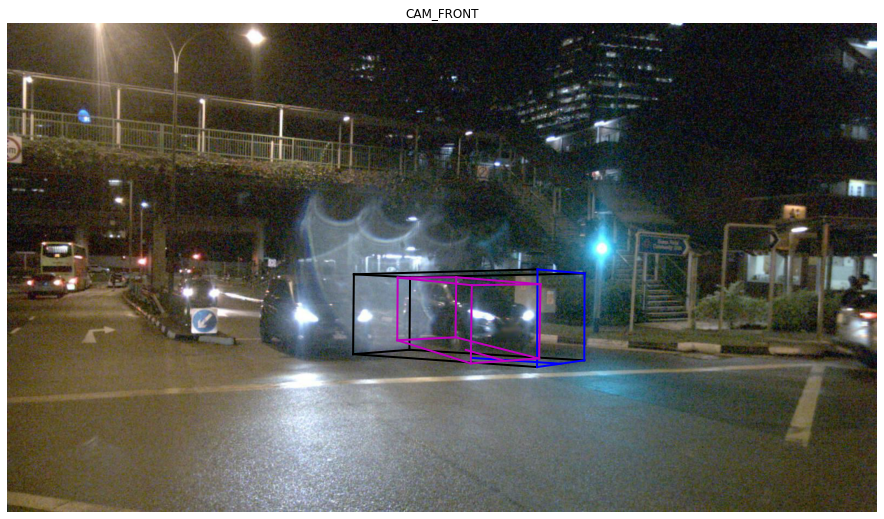

In [10]:
# sample index to predict 
idx = 25 # Idx test max 283 - 92 - 25 - 28

# Make a prediction with random forest model
pred_test = svr_mo.predict(X_test_scaled[idx, :].reshape(1, -1))

# Extract relevant info of the prediction
fast_test = y_test_tokens.to_numpy()
sample_token, cam_token, ann_token, label = fast_test[idx, :]

# Obtaining metadata of the ground truth
sensor_laser = 'LIDAR_TOP'
sample_metadata = nusc.get('sample', sample_token)
point_data = nusc.get('sample_data', sample_metadata['data'][sensor_laser])

# Obtaining ground truth bounding box in Lidar coordinate frame
gt_box = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')

# Compare ground truth vs prediction
print('Predicted values: ', pred_test)
print('Ground truth values: ', y_test[idx, :])

# Create a Quaternion with the orientation of the predicted vehicle
q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
# Create the bounding box object 
bbox = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label,token = sample_token)
# Make a deepcopy of the results in the LiDAR frame
lidar_box = copy.deepcopy(bbox)
# Plot the results
plot_3d_image_(nusc, cam_token, label, sample_token, bbox, gt_bbox_3d = gt_box)

In [11]:
# Mapping predicted bounding box to world coordinate frame
#bbox_map_world = pred_to_world(nusc, point_data['token'], lidar_box, pointsensor_channel = 'LIDAR_TOP')
bbox_map_world = copy.deepcopy(lidar_box)
# Obtain box parameters
#box = nusc.get_box(ann_token)
box = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')
    
print('The predicted bounding box in the world coordinate frame is: \n{}'.format(lidar_box))
print('The ground truth bounding box in the world coordinate frame is: \n{}'.format(box))

The predicted bounding box in the world coordinate frame is: 
label: nan, score: nan, xyz: [0.20, 14.79, -0.57], wlh: [1.85, 4.45, 1.69], rot axis: [-0.00, -0.00, -1.00], ang(degrees): 36.51, ang(rad): 0.64, vel: nan, nan, nan, name: vehicle, token: b993550e60054741983f8052ba97b0b0
The ground truth bounding box in the world coordinate frame is: 
label: nan, score: nan, xyz: [0.20, 17.31, -0.60], wlh: [1.71, 4.05, 1.64], rot axis: [-0.06, -0.04, 1.00], ang(degrees): -63.17, ang(rad): -1.10, vel: nan, nan, nan, name: vehicle.car, token: 5d8b62413fc543ea8d55eec26010231c


## Model evalaution through IoU in 3D and 2D (Test)

In [27]:
sensor_laser = 'LIDAR_TOP'

# Extract relevant info of the prediction
fast_test = y_test_tokens.to_numpy()

iou_3d_test = []
iou_bev_test = []

for idx in tqdm(range(X_test_scaled.shape[0]), desc = "Test evaluation"):

    # Make a prediction
    pred_test = svr_mo.predict(X_test_scaled[idx, :].reshape(1, -1))

    sample_token, cam_token, ann_token, label = fast_test[idx, :]

    # Obtaining metadata of the ground truth
    sample_metadata = nusc.get('sample', sample_token)
    point_data = nusc.get('sample_data', sample_metadata['data'][sensor_laser])
    
    # Obtaining attribute_name
    my_annotation_metadata =  nusc.get('sample_annotation', ann_token)
    my_attribute = nusc.get('attribute', my_annotation_metadata['attribute_tokens'][0])

    # Create a Quaternion with the orientation of the predicted vehicle
    q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
    
    # Create the bounding box object 
    bbox_predicted = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label,token = sample_token)
    
    # Mapping predicted bounding box to world coordinate frame
    #bbox_map_world = pred_to_world(nusc, point_data['token'], bbox, pointsensor_channel = 'LIDAR_TOP')
    
    # Obtain ground truth box parameters
    #box_gt = nusc.get_box(ann_token)
    box_gt = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')
    
    # Extracting the corners of the Bounding box
    corners_3d_predict = bbox_predicted.corners().T
    corners_3d_ground  = box_gt.corners().T
    
    # Computing the intersection volume
    IOU_3d, IOU_2d = box3d_iou(corners_3d_predict, corners_3d_ground, False)
    
    iou_3d_test.append(IOU_3d)
    iou_bev_test.append(IOU_2d)
    

Test evaluation: 100%|██████████| 283/283 [00:02<00:00, 128.97it/s]


In [28]:
print('The avg 3D IOU in Test is: {}'.format(sum(iou_3d_test) / len(iou_3d_test)))
print('The avg birds eye view in Test is: {}'.format(sum(iou_bev_test) / len(iou_bev_test)))

The avg 3D IOU in Test is: 0.2052981265324828
The avg birds eye view in Test is: 0.23694116576167845


## Model evalaution through IoU in 3D and 2D (Train)

In [24]:
sensor_laser = 'LIDAR_TOP'

# Extract relevant info of the prediction
fast_test = y_train_tokens.to_numpy()

iou_3d_train = []
iou_bev_train = []

for idx in tqdm(range(X_train_scaled.shape[0]), desc = "Train evaluation"):

    # Make a prediction
    pred_test = svr_mo.predict(X_train_scaled[idx, :].reshape(1, -1))

    sample_token, cam_token, ann_token, label = fast_test[idx, :]

    # Obtaining metadata of the ground truth
    sample_metadata = nusc.get('sample', sample_token)
    point_data = nusc.get('sample_data', sample_metadata['data'][sensor_laser])
    
    # Obtaining attribute_name
    my_annotation_metadata =  nusc.get('sample_annotation', ann_token)
    my_attribute = nusc.get('attribute', my_annotation_metadata['attribute_tokens'][0])

    # Create a Quaternion with the orientation of the predicted vehicle
    q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
    
    # Create the bounding box object 
    bbox_predicted = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label, token = sample_token)
    
    # Mapping predicted bounding box to world coordinate frame
    #bbox_map_world = pred_to_world(nusc, point_data['token'], bbox, pointsensor_channel = 'LIDAR_TOP')
    
    # Obtain ground truth box parameters
    #box_gt = nusc.get_box(ann_token)
    box_gt = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')
    
    # Extracting the corners of the Bounding box
    corners_3d_predict = bbox_predicted.corners().T
    corners_3d_ground  = box_gt.corners().T
    
    # Computing the intersection volume
    IOU_3d, IOU_2d = box3d_iou(corners_3d_predict, corners_3d_ground, False)
    
    iou_3d_train.append(IOU_3d)
    iou_bev_train.append(IOU_2d)

Train evaluation: 100%|██████████| 1128/1128 [00:08<00:00, 129.99it/s]


In [25]:
print('The avg 3D IOU in Training is: {}'.format(sum(iou_3d_train) / len(iou_3d_train)))
print('The avg birds eye view in Training is: {}'.format(sum(iou_3d_train) / len(iou_3d_train)))

The avg 3D IOU in Training is: 0.2995611212072173
The avg birds eye view in Training is: 0.2995611212072173


## JSON TEST

In [26]:
# JSON Format
submission ={ "meta": {
        "use_camera":   True,
        "use_lidar":    True,
        "use_radar":    False,
        "use_map":      False,
        "use_external": False
    },
    "results": {
    }
}

json_path =  os.getcwd() + '/dataset/json_test_set.json'

sensor_laser = 'LIDAR_TOP'

# Extract relevant info of the prediction
fast_test = y_test_tokens.to_numpy()

for idx in tqdm(range(X_train_scaled.shape[0]), desc = "JSON TEST"):

    # Make a prediction
    pred_test = svr_mo.predict(X_test_scaled[idx, :].reshape(1, -1))

    sample_token, cam_token, ann_token, label = fast_test[idx, :]

    # Obtaining metadata of the ground truth
    sample_metadata = nusc.get('sample', sample_token)
    point_data = nusc.get('sample_data', sample_metadata['data'][sensor_laser])
    
    # Obtaining attribute_name
    my_annotation_metadata =  nusc.get('sample_annotation', ann_token)
    my_attribute = nusc.get('attribute', my_annotation_metadata['attribute_tokens'][0])


    # Obtaining ground truth bounding box in Lidar coordinate frame
    gt_box = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')

    # Create a Quaternion with the orientation of the predicted vehicle
    q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
    
    # Create the bounding box object 
    bbox = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label,token = sample_token)
    
    # Mapping predicted bounding box to world coordinate frame
    bbox_map_world = pred_to_world(nusc, point_data['token'], bbox, pointsensor_channel = 'LIDAR_TOP')
    
    sample_result = {
        "sample_token": sample_token,
        "translation": [bbox_map_world.center[0],
                        bbox_map_world.center[1],
                        bbox_map_world.center[2]],
        "size": [bbox_map_world.wlh[0],
                 bbox_map_world.wlh[1],
                 bbox_map_world.wlh[2]],
        "rotation": [bbox_map_world.orientation[0],
                     bbox_map_world.orientation[1],
                     bbox_map_world.orientation[2],
                     bbox_map_world.orientation[3]],
        "velocity": [0,0],
        "detection_name": "car",
        "detection_score": 1,
        "attribute_name": my_attribute['name']    
    }
    
    # tries to add new JSON element
    try:
        submission["results"][sample_token].append(sample_result)
    
    # if there is an exception it means the sample_token doesn't exist
    except:
        submission["results"][sample_token]=[]
        submission["results"][sample_token].append(sample_result)

save_in_file(json_path, submission)

JSON TEST: 100%|██████████| 283/283 [00:01<00:00, 144.52it/s]


## JSON TRAIN

In [27]:
# JSON Format
submission ={ "meta": {
        "use_camera":   True,
        "use_lidar":    True,
        "use_radar":    False,
        "use_map":      False,
        "use_external": False
    },
    "results": {
    }
}

json_path =  os.getcwd() + '/dataset/json_train_set.json'

sensor_laser = 'LIDAR_TOP'

# Extract relevant info of the prediction
fast_train = y_train_tokens.to_numpy()

for idx in tqdm(range(X_train_scaled.shape[0]), desc = "JSON TRAIN"):

    # Make a prediction
    pred_test = svr_mo.predict(X_train_scaled[idx, :].reshape(1, -1))

    sample_token, cam_token, ann_token, label = fast_train[idx, :]

    # Obtaining metadata of the ground truth
    sample_metadata = nusc.get('sample', sample_token)
    point_data = nusc.get('sample_data', sample_metadata['data'][sensor_laser])
    
    # Obtaining attribute_name
    my_annotation_metadata =  nusc.get('sample_annotation', ann_token)
    my_attribute = nusc.get('attribute', my_annotation_metadata['attribute_tokens'][0])    

    # Obtaining ground truth bounding box in Lidar coordinate frame
    gt_box = target_to_cam(nusc, point_data['token'], ann_token, pointsensor_channel = 'LIDAR_TOP')

    # Create a Quaternion with the orientation of the predicted vehicle
    q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
    
    # Create the bounding box object 
    bbox = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label,token = sample_token)
    
    # Mapping predicted bounding box to world coordinate frame
    bbox_map_world = pred_to_world(nusc, point_data['token'], bbox, pointsensor_channel = 'LIDAR_TOP')
    
    sample_result = {
        "sample_token": sample_token,
        "translation": [bbox_map_world.center[0],
                        bbox_map_world.center[1],
                        bbox_map_world.center[2]],
        "size": [bbox_map_world.wlh[0],
                 bbox_map_world.wlh[1],
                 bbox_map_world.wlh[2]],
        "rotation": [bbox_map_world.orientation[0],
                     bbox_map_world.orientation[1],
                     bbox_map_world.orientation[2],
                     bbox_map_world.orientation[3]],
        "velocity": [0,0],
        "detection_name": "car",
        "detection_score": 1,
        "attribute_name": my_attribute['name']    
    }
    
    # tries to add new JSON element
    try:
        submission["results"][sample_token].append(sample_result)
    
    # if there is an exception it means the sample_token doesn't exist
    except:
        submission["results"][sample_token]=[]
        submission["results"][sample_token].append(sample_result)

save_in_file(json_path, submission)

JSON TRAIN: 100%|██████████| 1128/1128 [00:07<00:00, 147.31it/s]


## Evaluation

DetectionConfig: https://github.com/nutonomy/nuscenes-devkit/blob/c4db7fccac25bcc57686d71ba930c9272b3ffdfe/python-sdk/nuscenes/eval/detection/data_classes.py#L14

DtectionEval: https://github.com/nutonomy/nuscenes-devkit/blob/c4db7fccac25bcc57686d71ba930c9272b3ffdfe/python-sdk/nuscenes/eval/detection/evaluate.py#L44

Help: https://github.com/nutonomy/nuscenes-devkit/issues/390

Detection config example: https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/eval/detection/configs/detection_cvpr_2019.json

In [24]:
from nuscenes.eval.detection.data_classes import DetectionConfig

result_path =  os.getcwd() + '/dataset/json_test_set.json'
output_dir = os.getcwd() + '/dataset/eval_output'


with open('dataset/detection_config.json', 'r') as f:
        data = json.load(f)
        
cfg_ = DetectionConfig.deserialize(data)

DetectionEval(nusc, config = cfg_, result_path = result_path, eval_set = 'mini_val', output_dir = output_dir).main()

 38%|███▊      | 31/81 [00:00<00:00, 305.59it/s]

Initializing nuScenes detection evaluation
Loaded results from /home/sherlock/Documents/3d_obj_detection/dataset/json_test_set.json. Found detections for 212 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 286.00it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 283
=> After distance based filtering: 283
=> After LIDAR points based filtering: 283
=> After bike rack filtering: 283
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Accumulating metric data...
Calculating metrics...
Rendering PR and TP curves
Saving metrics to: /home/sherlock/Documents/3d_obj_detection/dataset/eval_output
mAP: 0.0000
mATE: 1.0000
mASE: 1.0000
mAOE: 1.0000
mAVE: 1.0000
mAAE: 1.0000
NDS: 0.0000
Eval time: 0.1s

Per-class results:
Object Class	AP	ATE	ASE	AOE	AVE	AAE
car	0.000	1.000	1.000	1.000	1.000	1.000
truck	0.000	1.000	1.000	1.000	1.000	1.000
bus	0.000	1.000	1.000	1.000	1.000	1.000
trailer	0.000	1.000	1.000	1.000	1.000	1.000
construction_vehicle	0.000	1.000	1.000	1.000	1.000	1.000
pedestrian	0.000	1.000	1.000	1.000	1.000	1.000
mot

{'label_aps': defaultdict(<function nuscenes.eval.detection.data_classes.DetectionMetrics.__init__.<locals>.<lambda>()>,
             {'car': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'truck': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'bus': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'trailer': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'construction_vehicle': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'pedestrian': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'motorcycle': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'bicycle': defaultdict(float,
                          {0.5: 0.0